# Image classificartion with EfficientNetB0
<br>Last updated on 10/02/2023</br>
<br>Objective: We aim to classify images into 10 classes of custom animal dataset using EfficientNetB0</br>
credit:<br>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html<br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html<br>
https://www.kaggle.com/datasets/alessiocorrado99/animals10<br>

In [1]:
! nvidia-smi

Wed Aug 30 08:00:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Download dataset

In [2]:
!wget https://github.com/pvateekul/2110446_DS_2022s2/raw/main/code/Week05_Intro_Deep_learning/data/Dataset_animal2.zip

--2023-08-30 08:00:37--  https://github.com/pvateekul/2110446_DS_2022s2/raw/main/code/Week05_Intro_Deep_learning/data/Dataset_animal2.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pvateekul/2110446_DS_2022s2/main/code/Week05_Intro_Deep_learning/data/Dataset_animal2.zip [following]
--2023-08-30 08:00:37--  https://raw.githubusercontent.com/pvateekul/2110446_DS_2022s2/main/code/Week05_Intro_Deep_learning/data/Dataset_animal2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29663352 (28M) [application/zip]
Saving to: ‘Dataset_animal2.zip’

Dataset_animal2.zip 100%[===================>]  28

In [3]:
!unzip -q -o 'Dataset_animal2.zip'

In [4]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 32

In [8]:
class AnimalDataset(Dataset):

    def __init__(self,
                 img_dir,
                 transforms=None):

        super().__init__()
        label_image = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
        self.input_dataset = list()
        label_num = 0
        for label in label_image:
            _, _, files = next(os.walk(os.path.join(img_dir,label)))
            for image_name in files:
                input = [os.path.join(img_dir,label,image_name),label_num] # [image_path, label_num]
                self.input_dataset.append(input)
            label_num += 1

        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx):
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = AnimalDataset('./Dataset_animal2/train',transform_train)
valset = AnimalDataset('./Dataset_animal2/val',transform)
testset = AnimalDataset('./Dataset_animal2/test',transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
trainset.__len__(), valset.__len__(), testset.__len__()

(1400, 300, 300)

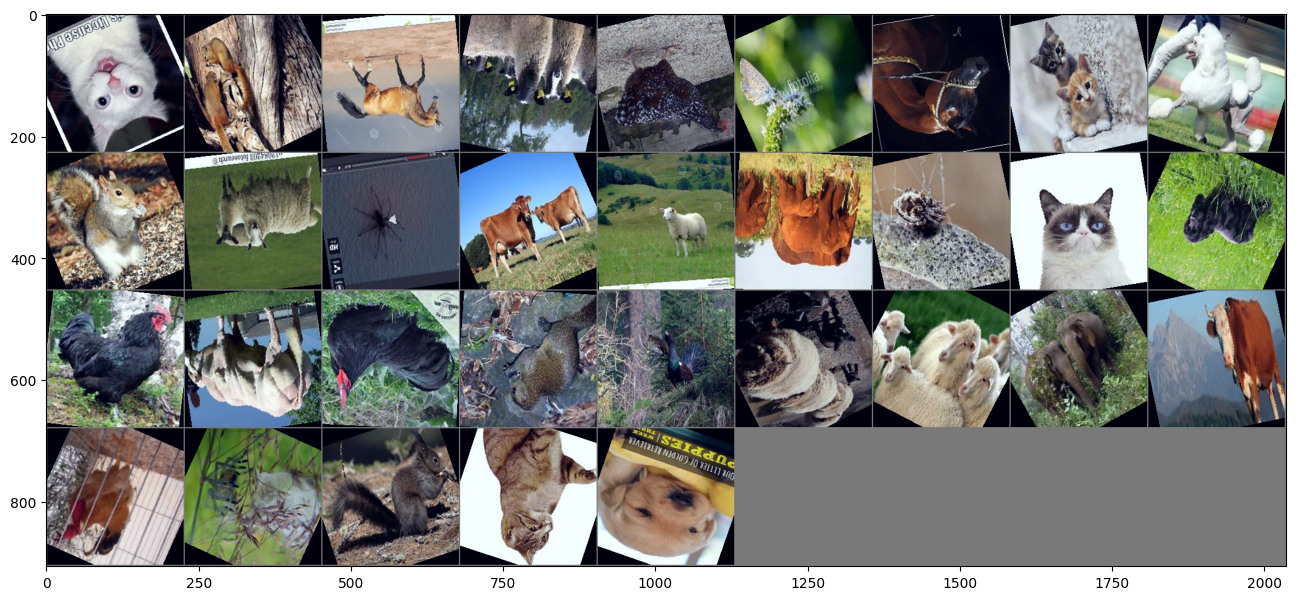

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [11]:
# print labels
for i in range(batch_size//nrow + 1 if batch_size % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

1   9   6   7   2   0   6   1   4  
9   7   8   3   7   5   8   1   4  
2   3   2   9   2   7   7   5   3  
2   8   9   1   4  


In [12]:
import torch.nn as nn
import torch.nn.functional as F

#pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
#net.classifier[1] = nn.Linear(1280, 102)
#net = net.to(device)
#mobile_net
num_classes=10
model_ft = torchvision.models.efficientnet_b0(pretrained=True)
model_ft.classifier[-1] = nn.Sequential(
    nn.Linear(in_features=1280, out_features=num_classes),
    nn.Softmax(dim=1)
        )

net = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.8MB/s]


In [13]:
from torchsummary import summary
summary(net, (3, 224, 224), batch_size = 64)
#from torchinfo import summary as summary_info
#summary_info(net, input_size = (128, 3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 112, 112]             864
       BatchNorm2d-2         [64, 32, 112, 112]              64
              SiLU-3         [64, 32, 112, 112]               0
            Conv2d-4         [64, 32, 112, 112]             288
       BatchNorm2d-5         [64, 32, 112, 112]              64
              SiLU-6         [64, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [64, 32, 1, 1]               0
            Conv2d-8              [64, 8, 1, 1]             264
              SiLU-9              [64, 8, 1, 1]               0
           Conv2d-10             [64, 32, 1, 1]             288
          Sigmoid-11             [64, 32, 1, 1]               0
SqueezeExcitation-12         [64, 32, 112, 112]               0
           Conv2d-13         [64, 16, 112, 112]             512
      BatchNorm2d-14         [64, 16, 1

In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [15]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 20

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Animal10-efficientnetb0.pth'

for epoch in range(epochs):  # loop over the dataset multiple times

    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # aggregate statistics
            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()

    optimizer.zero_grad()

    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1

    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss

print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 2.241, acc: 39.5%, f1-score: 38.2%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 2.047, acc: 71.67%, f1-score: 68.43%, support: 300
epoch 2 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.841, acc: 74.57%, f1-score: 71.23%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.658, acc: 84.0%, f1-score: 81.64%, support: 300
epoch 3 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.646, acc: 85.86%, f1-score: 85.11%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.573, acc: 92.33%, f1-score: 92.3%, support: 300
epoch 4 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.586, acc: 90.21%, f1-score: 90.2%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.55, acc: 92.33%, f1-score: 92.37%, support: 300
epoch 5 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.557, acc: 92.93%, f1-score: 92.89%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.54, acc: 94.33%, f1-score: 94.38%, support: 300
epoch 6 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.537, acc: 93.93%, f1-score: 93.92%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.54, acc: 94.33%, f1-score: 94.31%, support: 300
epoch 7 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.529, acc: 94.93%, f1-score: 94.94%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.534, acc: 94.67%, f1-score: 94.68%, support: 300
epoch 8 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.522, acc: 94.93%, f1-score: 94.93%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.532, acc: 94.33%, f1-score: 94.32%, support: 300
epoch 9 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.505, acc: 96.79%, f1-score: 96.79%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.519, acc: 95.33%, f1-score: 95.33%, support: 300
epoch 10 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.505, acc: 96.29%, f1-score: 96.28%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.527, acc: 94.67%, f1-score: 94.68%, support: 300
epoch 11 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.501, acc: 96.71%, f1-score: 96.71%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.527, acc: 94.67%, f1-score: 94.66%, support: 300
epoch 12 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.497, acc: 97.14%, f1-score: 97.15%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.521, acc: 94.67%, f1-score: 94.66%, support: 300
epoch 13 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.49, acc: 98.07%, f1-score: 98.07%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.522, acc: 95.0%, f1-score: 95.01%, support: 300
epoch 14 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.489, acc: 98.14%, f1-score: 98.14%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.522, acc: 94.33%, f1-score: 94.37%, support: 300
epoch 15 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.484, acc: 98.29%, f1-score: 98.29%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.515, acc: 95.33%, f1-score: 95.33%, support: 300
epoch 16 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.484, acc: 98.29%, f1-score: 98.29%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.528, acc: 94.67%, f1-score: 94.66%, support: 300
epoch 17 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.48, acc: 98.36%, f1-score: 98.36%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.513, acc: 95.0%, f1-score: 95.0%, support: 300
epoch 18 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.481, acc: 98.64%, f1-score: 98.64%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.517, acc: 95.0%, f1-score: 95.03%, support: 300
epoch 19 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.477, acc: 98.93%, f1-score: 98.93%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.512, acc: 94.67%, f1-score: 94.67%, support: 300
epoch 20 
Training ...


  0%|          | 0/44 [00:00<?, ?it/s]

training loss: 1.481, acc: 98.71%, f1-score: 98.72%, support: 1400
validating ...


  0%|          | 0/10 [00:00<?, ?it/s]

validation loss: 1.528, acc: 94.67%, f1-score: 94.68%, support: 300
Finished Training


In [16]:
min_val_loss

1.5122868180274964

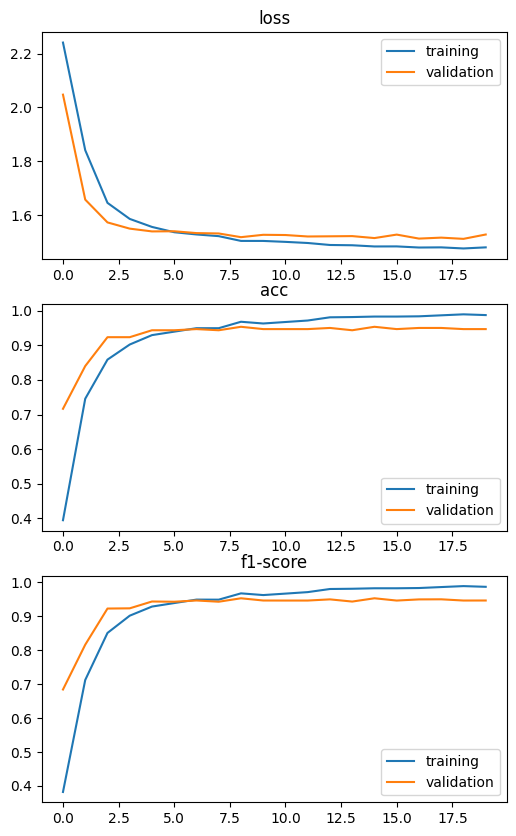

In [17]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()

In [18]:
PATH = './Animal10-efficientnetb0.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )

    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

testing ...


  0%|          | 0/10 [00:00<?, ?it/s]

testing loss: 1.504
              precision    recall  f1-score   support

           0     0.9677    1.0000    0.9836        30
           1     0.9655    0.9333    0.9492        30
           2     0.9667    0.9667    0.9667        30
           3     0.9333    0.9333    0.9333        30
           4     0.8438    0.9000    0.8710        30
           5     0.9677    1.0000    0.9836        30
           6     0.9355    0.9667    0.9508        30
           7     1.0000    0.9333    0.9655        30
           8     1.0000    1.0000    1.0000        30
           9     1.0000    0.9333    0.9655        30

    accuracy                         0.9567       300
   macro avg     0.9580    0.9567    0.9569       300
weighted avg     0.9580    0.9567    0.9569       300



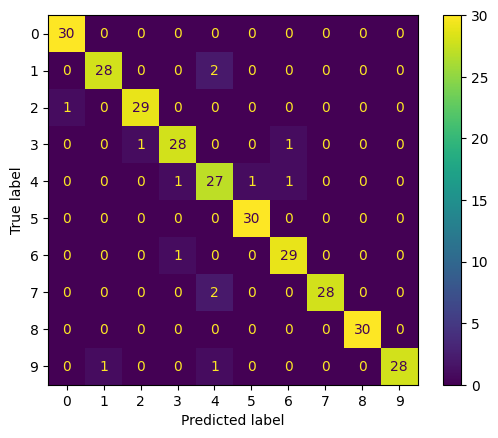

In [20]:
disp.plot()
plt.show()